In [46]:
!pip install scikit-optimize

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 KB 2.1 MB/s eta 0:00:00a 0:00:01


In [1]:
import skopt
from skopt.space import Real, Categorical, Integer
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier # Rede neural
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


In [3]:
df = pd.read_csv("Churn_Bank.csv")
print("Quantidade de registros: " + str(len(df)))

Quantidade de registros: 10000


# Preparação do dataset

Como pode ser observado, o dataset possui 10.000 registros, e não possui valores nulos, possuindo atributos do tipo float, int e strings.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Nem todos os atributos do dataset são necessarios para o treinamento do modelo. \
RowNumber é apenas o número da linha no dataset. \
CustomerId é o id do cliente e Surname é o sobre nome do cliente. ambos não tem nenhuma relevancia para o modelo, pois o objetivo
é generalizar o modelo para qualquer cliente que possa ter, e ter um atributo de sobrenome poderia limitar o modelo aos clientes conhecidos.

In [5]:
# Remove algumas das variaveis sem relevancia
df = df.drop("RowNumber", axis=1) # numero da linha
df = df.drop("CustomerId", axis=1) # id do cliente
df = df.drop("Surname", axis=1) # Sobrenome dos clientes

Alguns atributos como Geography e Gender, são atributos do tipo categorico, para o modelo usado é mais adequado padroniza-los para um valor numerico. No caso de Geography, será dado um numero inteiro para representar cada pais. Para o atributo genero, será dado um valor inteiro para cada genero.

In [6]:
le = LabelEncoder()
Geography = df['Geography']
encoded = le.fit_transform(df["Geography"])
df = df.drop("Geography", axis=1)
df["Geography"] = encoded

In [7]:
Gender = df['Gender']
encoded = le.fit_transform(df["Gender"])
df = df.drop("Gender", axis=1) # sobre nome
df["Gender"] = encoded

Para os atributos do tipo numerico, como Balance e EstimatedSalary, eles são valores reais, esses dois atributos serão normalizado par um intervalo entre 0 e 1. \

Para os atributos do tipo numerico que são inteiros como Age e CreditScore. Ao inves de tratar cada idade ou CreditScore como esta atualmente eles serão ajustados para intevalos para facilitar a compreensão do modelo.

In [8]:
scaler = MinMaxScaler()
atributos_floats = ["Balance", "EstimatedSalary"]
df[atributos_floats] = scaler.fit_transform(df[atributos_floats])

In [9]:
idade_intervalo = [0, 20, 30, 40, 50, 60, 70, 80 ,90 ,100 ]
df["Age"] = pd.cut(df["Age"], idade_intervalo, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])

In [10]:
credito_intervalo = [300, 400, 500, 600, 700, 800, 900 ]
nomes = [1, 2, 3, 4, 5, 6]
df["CreditScore"] = pd.cut(df["CreditScore"], credito_intervalo, labels=nomes)

In [11]:
df.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography,Gender
0,4,4,2,0.000000,1,1,1,0.506735,1,0,0
1,4,4,1,0.334031,1,0,1,0.562709,0,2,0
2,3,4,8,0.636357,3,1,0,0.569654,1,0,0
3,4,3,1,0.000000,2,0,0,0.469120,0,0,0
4,6,4,2,0.500246,1,1,1,0.395400,0,2,0


# Treinar Modelo

## Treinamento sem ajuste de hiperparâmetros

Para realizar o treinamento com validação cruzada, é necessário serpara o conjunto de treino em K-fold conjuntos. Onde em cada iteração, parte dos conjuntos serão usados para treinamento e outra parte para validação. 

Inicialmente eu separei em dois conjuntos, um de treino (X_train) e um de teste (X_test), cada um com 90% e 10% dos dados respectivamente. Para a validação cruzada o conjunto de treino será divido em k grupos, e a função cross_validate será responsavel por essa divisão e realizará a validação cruzda e retornara a acurácia do k modelos.

In [47]:
X = df.drop("Exited", axis=1)  # Remove da conjunto de teino o atributo Exited, pois ele sera usado para classificar os dados
y = df["Exited"]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) # separa 10% dos dados para teste
print("Dados para Treino: " + str(len(X_train)))
print("Dados para Teste: " + str(len(X_test)))

Dados para Treino: 9000
Dados para Teste: 1000


In [42]:
X_testo = X_test
X_testo["Exited"] = y_test

In [43]:
X_testo

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography,Gender,Exited
6252,3,3,3,0.385452,2,0,0,0.208904,1,1,0
4684,4,4,1,0.000000,2,1,1,0.731908,0,1,0
1731,4,4,4,0.000000,2,1,0,0.292777,2,0,0
4742,3,5,8,0.474902,2,1,1,0.853422,1,1,0
4521,3,2,7,0.498194,1,1,1,0.573346,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3921,3,5,3,0.000000,2,1,0,0.129173,0,1,1
6685,4,3,8,0.000000,2,1,0,0.192811,0,1,0
3194,4,2,3,0.470701,1,1,0,0.306260,0,0,0
1941,2,4,3,0.354390,1,1,0,0.348464,2,1,0


In [45]:

X_testo.to_csv("df_teste.csv")

### Random Florest

In [19]:
# Testei o modelo com um valor muito baixo para o n_estimators, justamente para ter mais espaço para melhoria
modelo = RandomForestClassifier(n_estimators=1, random_state=None)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
resultados = cross_validate(modelo, X_train, y_train, cv=folds, scoring="accuracy")
print(resultados["test_score"])

[0.76777778 0.775      0.79388889 0.78166667 0.76666667]


In [38]:
modelo = RandomForestClassifier(n_estimators=1, random_state=None)
modelo.fit(X_train, y_train)

pred_labels = modelo.predict(X_test)
actual_labels = np.array(y_test)

print('Accuracy: ', round(float(accuracy_score(actual_labels, pred_labels))*100, 4), '%')
print('Accuracy Balanced: ', round(float(balanced_accuracy_score(actual_labels, pred_labels))*100, 4), '%')
print('\nClassification Stats:')
print(classification_report(actual_labels, pred_labels))

Accuracy:  77.8 %
Accuracy Balanced:  65.082 %

Classification Stats:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       809
           1       0.42      0.45      0.43       191

    accuracy                           0.78      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.78      0.78      0.78      1000



### Rede Neural

In [16]:
# Testei o modelo com um valor muito baixo para o hidden_layer_sizes, justamente para ter mais espaço para melhoria

modelo = MLPClassifier(hidden_layer_sizes=(2, 2, 1),
                        batch_size = 32,
                        activation='logistic',
                        solver='adam',
                        learning_rate = "adaptive",
                        max_iter=20,
                        random_state = 42,)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
resultados = cross_validate(modelo, X_train, y_train, cv=folds, scoring="accuracy")
print(resultados["test_score"])

/home/marcos/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/marcos/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/marcos/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/marcos/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


[0.795      0.795      0.795      0.795      0.79444444]


/home/marcos/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [19]:
modelo = MLPClassifier(hidden_layer_sizes=(2, 2, 1),
                        batch_size = 32,
                        activation='logistic',
                        solver='adam',
                        learning_rate = "adaptive",
                        max_iter=20,
                        random_state = 42,)

modelo.fit(X_train, y_train)

pred_labels = modelo.predict(X_test)
actual_labels = np.array(y_test)

print('Accuracy: ', round(float(accuracy_score(actual_labels, pred_labels))*100, 4), '%')
print('Accuracy Balanced: ', round(float(balanced_accuracy_score(actual_labels, pred_labels))*100, 4), '%')
print('\nClassification Stats:')
print(classification_report(actual_labels, pred_labels))

Accuracy:  80.9 %
Accuracy Balanced:  50.0 %

Classification Stats:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       809
           1       0.00      0.00      0.00       191

    accuracy                           0.81      1000
   macro avg       0.40      0.50      0.45      1000
weighted avg       0.65      0.81      0.72      1000



/home/marcos/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/marcos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/marcos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/marcos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarnin

## Ajuste de Hiperparâmetros

### Ramdom Florest

In [20]:
# Intervalo dos hyperparametros

n_estimators = Integer(low=1, high=100, name='n_estimators')


dimensions = [n_estimators]

In [24]:
iteracao = 1
@use_named_args(dimensions=dimensions)
def fitness(n_estimators):
    global iteracao
    modelo = RandomForestClassifier(n_estimators=n_estimators, random_state=None)
    modelo.fit(X_train, y_train)

    pred_labels = modelo.predict(X_test)
    actual_labels = np.array(y_test)

    print(str(iteracao) + '- Accuracy: ', round(float(accuracy_score(actual_labels, pred_labels))*100, 4), '%')
    iteracao +=1
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -float(accuracy_score(actual_labels, pred_labels))*100

In [25]:
res = gp_minimize(func=fitness,
                    dimensions=dimensions,
                    acq_func='EI',           # Expected Improvement.
                    n_initial_points = 15,   # numero de pontos aleatórios testados, antes de fazer a aproximação.
                    n_calls= 100,             # Numero total de iterações da função.
                    )   

1- Accuracy:  85.9 %
2- Accuracy:  86.6 %
3- Accuracy:  86.8 %
4- Accuracy:  86.8 %
5- Accuracy:  86.4 %
6- Accuracy:  86.8 %
7- Accuracy:  85.2 %
8- Accuracy:  86.1 %
9- Accuracy:  86.3 %
10- Accuracy:  86.6 %
11- Accuracy:  86.6 %
12- Accuracy:  87.2 %
13- Accuracy:  86.4 %
14- Accuracy:  86.7 %
15- Accuracy:  86.9 %
16- Accuracy:  86.4 %
17- Accuracy:  86.4 %
18- Accuracy:  86.3 %
19- Accuracy:  86.9 %
20- Accuracy:  86.9 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [66] before, using random point [19]
  warnings.warn(


21- Accuracy:  85.8 %
22- Accuracy:  86.7 %
23- Accuracy:  86.7 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [60]
  warnings.warn(


24- Accuracy:  86.5 %
25- Accuracy:  86.8 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [89]
  warnings.warn(


26- Accuracy:  87.1 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [92]
  warnings.warn(


27- Accuracy:  85.7 %
28- Accuracy:  86.6 %
29- Accuracy:  87.2 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [46] before, using random point [55]
  warnings.warn(


30- Accuracy:  86.1 %
31- Accuracy:  86.1 %
32- Accuracy:  86.6 %
33- Accuracy:  86.7 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [44]
  warnings.warn(


34- Accuracy:  86.8 %
35- Accuracy:  78.5 %
36- Accuracy:  85.8 %
37- Accuracy:  87.1 %
38- Accuracy:  86.0 %
39- Accuracy:  87.1 %
40- Accuracy:  87.1 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [83] before, using random point [97]
  warnings.warn(


41- Accuracy:  86.8 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [82] before, using random point [61]
  warnings.warn(


42- Accuracy:  86.4 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [82] before, using random point [35]
  warnings.warn(


43- Accuracy:  87.0 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [82] before, using random point [16]
  warnings.warn(


44- Accuracy:  86.3 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [83] before, using random point [63]
  warnings.warn(


45- Accuracy:  86.7 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [83] before, using random point [54]
  warnings.warn(


46- Accuracy:  87.1 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [83] before, using random point [10]
  warnings.warn(


47- Accuracy:  85.9 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [83] before, using random point [57]
  warnings.warn(


48- Accuracy:  86.7 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [83] before, using random point [82]
  warnings.warn(


49- Accuracy:  86.9 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [9]
  warnings.warn(


50- Accuracy:  85.5 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [7]
  warnings.warn(


51- Accuracy:  84.9 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [65]
  warnings.warn(


52- Accuracy:  87.1 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [59]
  warnings.warn(


53- Accuracy:  87.0 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [80]
  warnings.warn(


54- Accuracy:  86.8 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [4]
  warnings.warn(


55- Accuracy:  84.7 %
56- Accuracy:  86.3 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [37]
  warnings.warn(


57- Accuracy:  86.5 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [5]
  warnings.warn(


58- Accuracy:  84.7 %
59- Accuracy:  87.3 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [50] before, using random point [68]
  warnings.warn(


60- Accuracy:  87.4 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [50] before, using random point [62]
  warnings.warn(


61- Accuracy:  86.8 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [50] before, using random point [57]
  warnings.warn(


62- Accuracy:  86.5 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [50] before, using random point [42]
  warnings.warn(


63- Accuracy:  87.4 %
64- Accuracy:  85.7 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [78]
  warnings.warn(


65- Accuracy:  86.9 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [85]
  warnings.warn(


66- Accuracy:  86.8 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [15]
  warnings.warn(


67- Accuracy:  86.0 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [49]
  warnings.warn(


68- Accuracy:  87.0 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [67]
  warnings.warn(


69- Accuracy:  86.7 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [86]
  warnings.warn(


70- Accuracy:  87.0 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [74]
  warnings.warn(


71- Accuracy:  87.3 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [92]
  warnings.warn(


72- Accuracy:  87.3 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [74]
  warnings.warn(


73- Accuracy:  87.0 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [5]
  warnings.warn(


74- Accuracy:  84.0 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [62]
  warnings.warn(


75- Accuracy:  87.2 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [42]
  warnings.warn(


76- Accuracy:  86.8 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [95]
  warnings.warn(


77- Accuracy:  86.4 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [79]
  warnings.warn(


78- Accuracy:  87.0 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [30]
  warnings.warn(


79- Accuracy:  86.9 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [46]
  warnings.warn(


80- Accuracy:  86.5 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [81]
  warnings.warn(


81- Accuracy:  87.0 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [16]
  warnings.warn(


82- Accuracy:  87.2 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [94]
  warnings.warn(


83- Accuracy:  86.7 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [88]
  warnings.warn(


84- Accuracy:  87.0 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [28]
  warnings.warn(


85- Accuracy:  86.8 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [4]
  warnings.warn(


86- Accuracy:  83.8 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [8]
  warnings.warn(


87- Accuracy:  85.8 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [93]
  warnings.warn(


88- Accuracy:  87.0 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [12]
  warnings.warn(


89- Accuracy:  87.0 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [98]
  warnings.warn(


90- Accuracy:  86.8 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [90]
  warnings.warn(


91- Accuracy:  87.3 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [92]
  warnings.warn(


92- Accuracy:  87.0 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [86]
  warnings.warn(


93- Accuracy:  87.3 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [69]
  warnings.warn(


94- Accuracy:  87.0 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [62]
  warnings.warn(


95- Accuracy:  86.9 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [9]
  warnings.warn(


96- Accuracy:  85.1 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [10]
  warnings.warn(


97- Accuracy:  86.7 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100] before, using random point [98]
  warnings.warn(


98- Accuracy:  85.5 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [88] before, using random point [43]
  warnings.warn(


99- Accuracy:  86.6 %


/home/marcos/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [88] before, using random point [13]
  warnings.warn(


100- Accuracy:  85.1 %


In [26]:
# Melhores parâmetros
print("Acuracia: " + str(res.fun*-1))
print("""Melhores parâmetros:
- n_estimators =  %d""" % (res.x[0]))

Acuracia: 87.4
Melhores parâmetros:
- n_estimators =  68


Como pode ser observado no grafico abaixo, houve uma pequena melhoria na acuracia, mas nada muito significativo.
Como a função de ajuste de hiperparametro é para minimização, foi necessario passar o valor da acuraria como negativo para que fosse feito a maximização da acuracia.

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

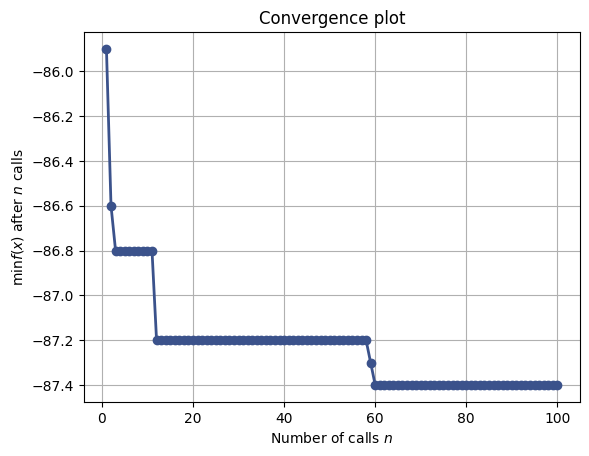

In [27]:
plot_convergence(res)

Modelo testado com os melhores hiperparâmetros encontrado

In [28]:
modelo = RandomForestClassifier(n_estimators=86, random_state=42)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
resultados = cross_validate(modelo, X_train, y_train, cv=folds, scoring="accuracy")
print(resultados["test_score"])

[0.84888889 0.84555556 0.86       0.86       0.84888889]


Os resultados apresentados pela validação cruzada sem o ajuste dos hiperparâmetros: 0.76777778 0.775      0.79388889 0.78166667 0.76666667 \
Os resultados apresentados pela validação cruzada com o ajuste dos hiperparâmetros: 0.84888889 0.84555556 0.86       0.86       0.84888889

Como pode ser observado apos testar 100 valores para o hiperparâmetro, houve uma melhora significativa nos resultados. \
Entretando, isso se deve ao fato de que para o modelo sem ajuste de hiperparametros, o n_estimators escolhido foi o menor possivel justamente para ter mais espaço de melhorar quando fizesse o ajsute de hiperparametros. e mesmo durante o ajuste a acuracia ficou por volta de 86% e 87%.

### Rede Neural

In [29]:
# Intervalo dos hyperparametros

neuronios = Integer(low=1, high=50, name='neuronios')
max_iter = Integer(low=10, high=1000, name='max_iter')


dimensions = [neuronios, max_iter]

In [34]:
@use_named_args(dimensions=dimensions)
def fitness(neuronios, max_iter):

    modelo = MLPClassifier(hidden_layer_sizes=(neuronios, neuronios, 1),
                        batch_size = 32,
                        activation='logistic',
                        solver='adam',
                        learning_rate = "adaptive",
                        max_iter=max_iter,
                        random_state = None,)

    modelo.fit(X_train, y_train)

    pred_labels = modelo.predict(X_test)
    actual_labels = np.array(y_test)

    print('Accuracy: ', round(float(accuracy_score(actual_labels, pred_labels))*100, 4), '%')


    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -float(accuracy_score(actual_labels, pred_labels))*100

In [35]:
res = gp_minimize(func=fitness,
                    dimensions=dimensions,
                    acq_func='EI',           # Expected Improvement.
                    n_initial_points = 8,   # numero de pontos aleatórios testados, antes de fazer a aproximação.
                    n_calls= 20,             # Numero total de iterações da função.
                    )   

Accuracy:  86.7 %
Accuracy:  86.6 %
Accuracy:  85.9 %


/home/marcos/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (223) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy:  84.4 %
Accuracy:  86.8 %


/home/marcos/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (129) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy:  84.1 %
Accuracy:  86.6 %
Accuracy:  86.6 %
Accuracy:  80.9 %
Accuracy:  86.0 %
Accuracy:  86.8 %
Accuracy:  84.5 %
Accuracy:  85.6 %


/home/marcos/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy:  80.9 %
Accuracy:  86.3 %
Accuracy:  86.0 %
Accuracy:  87.0 %
Accuracy:  80.9 %


/home/marcos/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (225) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy:  85.5 %
Accuracy:  85.5 %


In [36]:
# Melhores parâmetros
print("Acuracia: " + str(res.fun*-1))
print("""Melhores parâmetros:
- Quantidade de neuronios = %d
- max_iter =  %d""" % (res.x[0], res.x[1]))

Acuracia: 87.0
Melhores parâmetros:
- Quantidade de neuronios = 50
- max_iter =  359


<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

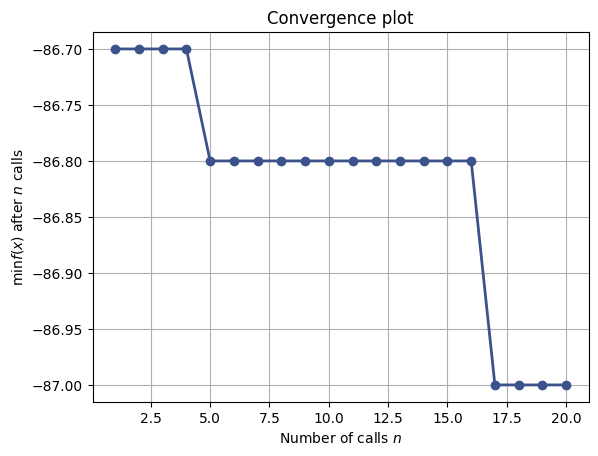

In [37]:
plot_convergence(res)

In [39]:
modelo_final = MLPClassifier(hidden_layer_sizes=(50, 50, 1),
                        batch_size = 32,
                        activation='logistic',
                        solver='adam',
                        learning_rate = "adaptive",
                        max_iter=359,
                        random_state = 42,)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
resultados = cross_validate(modelo, X_train, y_train, cv=folds, scoring="accuracy")
print(resultados["test_score"])

[0.85055556 0.85055556 0.85888889 0.805      0.85222222]


Os resultados apresentados pela validação cruzada sem o ajuste dos hiperparâmetros: 0.795      0.795      0.795      0.795      0.79444444 \
Os resultados apresentados pela validação cruzada com o ajuste dos hiperparâmetros: 0.85055556 0.85055556 0.85888889 0.805      0.85222222

Como pode ser observado mesmo apos testar 20 valores para o hiperparâmetro, houve uma melhora significativa. Entretando, isso se deve ao fato de que para o modelo sem ajuste de hiperparametros, a quantidade de neuronios e o max_iter escolhido foi o menor possivel justamente para ter mais espaço de melhorar quando fizesse o ajsute de hiperparametros. E mesmo nas acurácias dos testes, não houve uma acuracia maior que 85%. 

# Salvando Modelo

In [52]:
from joblib import dump
modelos = RandomForestClassifier(n_estimators=86, random_state=42)

modelos.fit(X_train, y_train)

pred_labels = modelos.predict(X_test)
actual_labels = np.array(y_test)

print('Accuracy: ', round(float(accuracy_score(actual_labels, pred_labels))*100, 4), '%')
print('Accuracy Balanced: ', round(float(balanced_accuracy_score(actual_labels, pred_labels))*100, 4), '%')
print('\nClassification Stats:')
print(classification_report(actual_labels, pred_labels))
dump(modelos, 'modelo_salvo.joblib')

Accuracy:  86.2 %
Accuracy Balanced:  71.4734 %

Classification Stats:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       809
           1       0.71      0.48      0.57       191

    accuracy                           0.86      1000
   macro avg       0.80      0.71      0.74      1000
weighted avg       0.85      0.86      0.85      1000



['modelo_salvo.joblib']